In [1]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve

2024-05-02 14:28:44.420025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_s = pd.read_csv("ML2.csv")

In [3]:
file_s.keys()

Index(['Student ID', 'Student Name', 'Date of Birth', 'Field of Study',
       'Year of Admission', 'Expected Year of Graduation', 'Current Semester',
       'Specialization', 'Fees', 'Discount on Fees'],
      dtype='object')

In [4]:
foo = file_s['Field of Study']

In [5]:
type(foo)

pandas.core.series.Series

In [6]:
field = file_s['Field of Study']
grad = file_s['Expected Year of Graduation']
sem = file_s['Current Semester']

In [7]:
set(field), set(grad), set(sem)

({'Chemical Engineering',
  'Civil Engineering',
  'Computer Science',
  'Electrical Engineering',
  'Mechanical Engineering'},
 {2017, 2018, 2019, 2020, 2021, 2022, 2023},
 {1, 2, 3, 4})

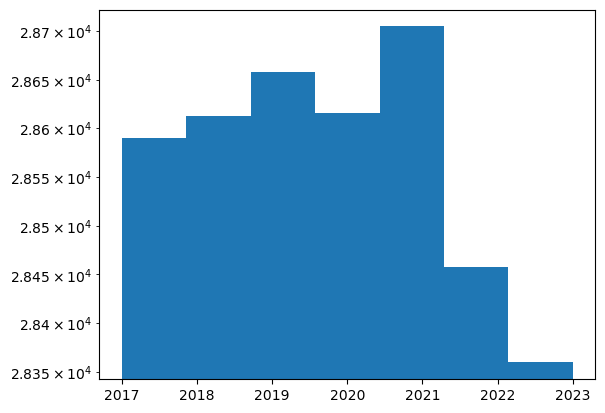

In [8]:
plt.hist(grad, 7)
plt.yscale('log')

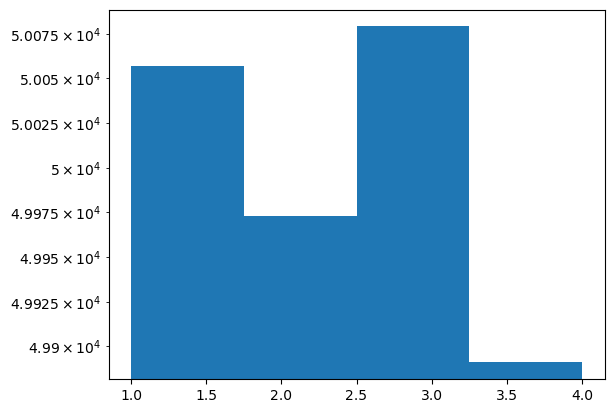

In [9]:
plt.hist(sem, 4)
plt.yscale('log')

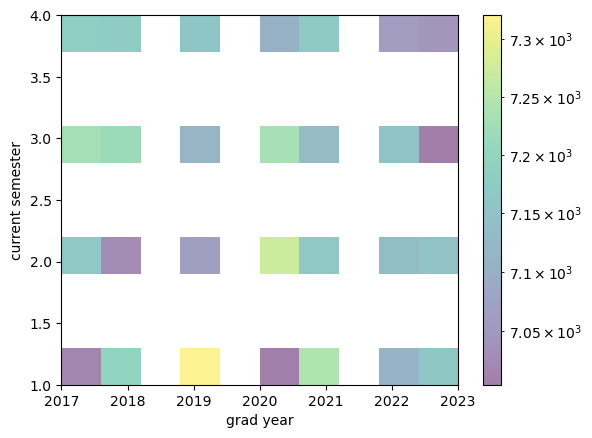

In [10]:
plt.hist2d(grad, sem, bins=10, alpha=0.5, norm='log')
plt.colorbar()
#plt.xlim(0,400)
#plt.ylim(0,900)
plt.xlabel('grad year')
plt.ylabel('current semester')
#plt.title("ht values less than 2.5 and between 2.5 and 3.1")
plt.show()

In [11]:
data = {'grad': grad, 'semester': sem}
df = pd.DataFrame(data)

In [12]:
df

,grad,semester
0,2017,3
1,2020,2
2,2022,1
3,2019,1
4,2018,1
...,...,...
199995,2021,4
199996,2019,3
199997,2023,1
199998,2018,1


In [48]:
sig = pd.DataFrame({'semester': sem})
back = pd.DataFrame({'grad': grad})

In [57]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
norm_sig = scaler.fit_transform(sig)
norm_back = scaler.fit_transform(back)

norm_sig_df = pd.DataFrame(norm_sig)
norm_back_df = pd.DataFrame(norm_back)

norm_total_df = pd.concat([norm_sig_df, norm_back_df])
norm_total_df

,0
0,0.448184
1,-0.446430
2,-1.341044
3,-1.341044
4,-1.341044
...,...
199995,0.502951
199996,-0.498181
199997,1.504083
199998,-0.998746


In [94]:
ones = np.full(len(norm_sig_df), 1)
zeros = np.full(len(norm_back_df), 0)

signal = ak.from_numpy(np.concatenate((ones, zeros)))
x = norm_total_df
y = signal

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [95]:
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [96]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [97]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [98]:
model.fit(x_train, y_train)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 8s 722us/step - accuracy: 0.6169 - loss: 0.6000


In [99]:
future = model(x_train).numpy()
future

array([[9.923740e-01],
       [9.986869e-01],
       [8.949997e-03],
       ...,
       [9.986869e-01],
       [6.740371e-07],
       [9.001828e-02]], dtype=float32)

In [100]:
future_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
future_model(x_test)

/Users/beccahudson/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (80000, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


<tf.Tensor: shape=(80000, 1), dtype=float32, numpy=
array([[0.99999994],
       [0.99999994],
       [0.99999994],
       ...,
       [0.99999994],
       [0.99999994],
       [0.99999994]], dtype=float32)>

In [101]:
y_probs = model.predict(x_test)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 656us/step


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(x_train, y_train)
probs = model.predict_proba(x_test)

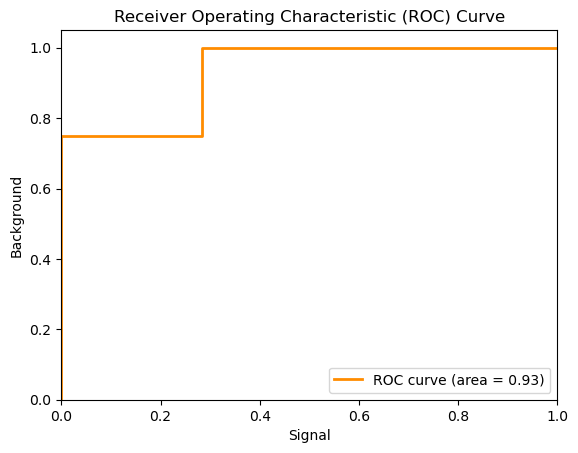

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Signal')
plt.ylabel('Background')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

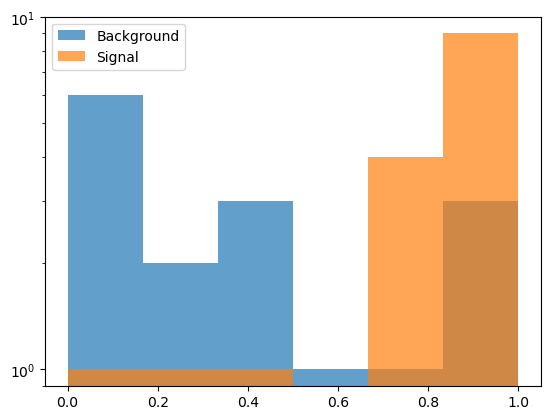

In [104]:
plt.hist(fpr, bins = 6, range = (0,1), label = "Background", alpha=0.7)
plt.hist(tpr, bins = 6, range = (0,1), label = "Signal", alpha=0.7)
plt.legend()
plt.yscale('log')
plt.show()

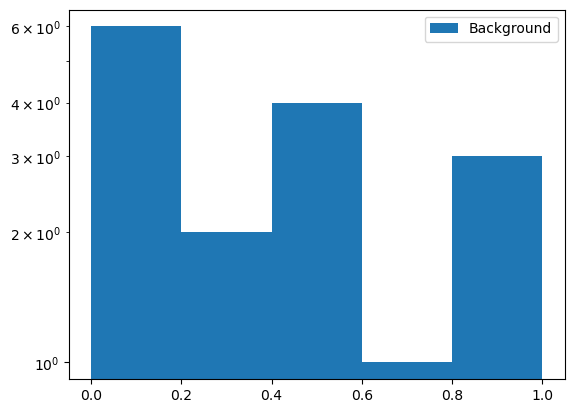

In [105]:
plt.hist(fpr, bins = 5, range = (0,1), label = "Background")
plt.legend()
plt.yscale('log')
plt.show()

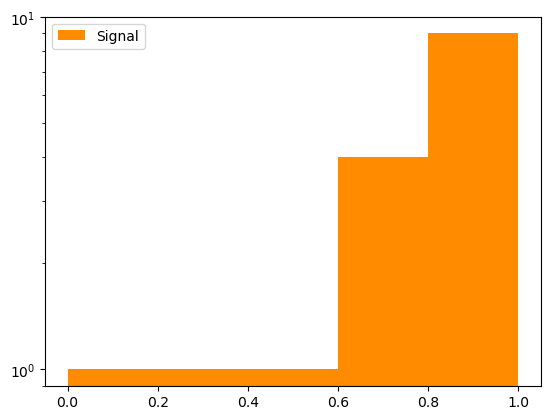

In [106]:
plt.hist(tpr, bins = 5, range = (0,1), label = "Signal", color='darkorange')
plt.legend()
plt.yscale('log')
plt.show()